In this file, we write necessary policy components to implement a custom Recurrent Replay model, which implements frameworks from the following papers: 

@misc{hausknecht2017deeprecurrentqlearningpartially,
      title={Deep Recurrent Q-Learning for Partially Observable MDPs}, 
      author={Matthew Hausknecht and Peter Stone},
      year={2017},
      eprint={1507.06527},
      archivePrefix={arXiv},
      primaryClass={cs.LG},
      url={https://arxiv.org/abs/1507.06527}, 
}

@inproceedings{
      kapturowski2018recurrent,
      title={Recurrent Experience Replay in Distributed Reinforcement Learning},
      author={Steven Kapturowski and Georg Ostrovski and Will Dabney and John Quan and Remi Munos},
      booktitle={International Conference on Learning Representations},
      year={2019},
      url={https://openreview.net/forum?id=r1lyTjAqYX},
}

It is important to note that we are creating R2D1 (D1 since we don't need distributed framework) which requires the following improvements on the standard DQN: 
1) Double DQN
2) Prioritized Experience Replay
3) Dueling Network
4) n-step Learning 

Additionally we credit: https://github.com/Curt-Park/rainbow-is-all-you-need for base implementation of DQN (with some rainbow elements)

In [67]:
# importing necessary libraries
import math
import os
import random
from collections import deque
from typing import Deque, Dict, List, Tuple, Any
import gymnasium
from gymnasium import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from segment_tree import MinSegmentTree, SumSegmentTree


Below we implement a DictReplayBuffer, that is adjusted for N-step learning. 

In [68]:
class DictReplayBufferNStep: 

    """
    A replay buffer that stores transitions (nested dictionary of NumPy arrays, since obs are returned as a dictionary) and supports N-step returns.
    """

    def __init__(
            self, 
            observation_space: spaces.Dict,
            buffer_size: int, 
            batch_size: int = 64, 
            n_step: int = 1, 
            gamma: float = 0.99,
    ): 
        
        # adding (o,a,o',r,d) to the buffer
        self.observations_buffer = {k: np.zeros([buffer_size, *v.shape], dtype=v.dtype) for k, v in observation_space.spaces.items()}                # observations
        self.next_observations_buffer = {k: np.zeros([buffer_size, *v.shape], dtype=v.dtype) for k, v in observation_space.spaces.items()}           # next observations
        self.actions_buffer = np.zeros([buffer_size], dtype=np.int64)                                                                                # actions
        self.rewards_buffer = np.zeros([buffer_size], dtype=np.float32)                                                                              # rewards
        self.dones_buffer = np.zeros([buffer_size], dtype=np.bool_)                                                                                  # dones  

        self.ptr, self.size, = 0, 0
        self.max_size, self.batch_size = buffer_size, batch_size

        # for N-step Learning
        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(
      self, 
      obs: Dict[str, np.ndarray], 
      act: float, 
      rew: float, 
      next_obs: Dict[str, np.ndarray], 
      done: bool
    ):      
        """
        Store a new transition in the replay buffer, using N-step returns.
        """

        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

         # single step transition is not ready
        if len(self.n_step_buffer) < self.n_step:
            return ()
        
        rew, next_obs, done = self._get_n_step_info(
            self.n_step_buffer, self.gamma
        )
        obs, act = self.n_step_buffer[0][:2]

        # store all obs keys in buffer 
        for k in obs:
            self.observations_buffer[k][self.ptr] = obs[k]
            self.next_observations_buffer[k][self.ptr] = next_obs[k]

        self.actions_buffer[self.ptr] = act
        self.rewards_buffer[self.ptr] = rew
        self.dones_buffer[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

        return self.n_step_buffer[0]  
    
    def sample_batch(
           self) -> Dict[str, Dict[str, np.ndarray]]:
        
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        
        return {
            'obs': {k: v[idxs] for k, v in self.observations_buffer.items()},
            'next_obs': {k: v[idxs] for k, v in self.next_observations_buffer.items()},
            'acts': self.actions_buffer[idxs],
            'rews': self.rewards_buffer[idxs],
            'done': self.dones_buffer[idxs],
            # for N-step Learning
            'indices': idxs,
        }

    def sample_batch_from_idxs(self, idxs: np.ndarray) -> Dict[str, Dict[str, np.ndarray]]:
        
        # for N-step Learning
        return {
            'obs': {k: v[idxs] for k, v in self.observations_buffer.items()},
            'next_obs': {k: v[idxs] for k, v in self.next_observations_buffer.items()},
            'acts': self.actions_buffer[idxs],
            'rews': self.rewards_buffer[idxs],
            'done': self.dones_buffer[idxs],
            }
    
    def _get_n_step_info(
            self,
            n_step_buffer: Deque,
            gamma: float,
    ) -> Tuple[float, Dict[str, np.ndarray], bool]:
        
        """
        Compute the N-step return for a given buffer of transitions.
        """

         # info of the last transition
        rew, next_obs, done = n_step_buffer[-1][-3:]
        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]
            rew = r + gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)
        return rew, next_obs, done
    
    def __len__(self) -> int:
        return self.size


Below we create a Prioritized Replay Buffer which is used to implement PER. Note that we inherit from the parent DictReplayBufferNStep class.

In [69]:
class PrioritizedDictReplayBuffer(DictReplayBufferNStep):

    """
    A prioritized replay buffer that stores transitions (with the observation being a dictionary) and supports N-step returns.

    Attributes:
        max_priority (float): max priority
        tree_ptr (int): next index of tree
        alpha (float): alpha parameter for prioritized replay buffer
        sum_tree (SumSegmentTree): sum tree for prior
        min_tree (MinSegmentTree): min tree for min prior to get max weight
    """

    def __init__(
            self, 
            observation_space: spaces.Dict,
            buffer_size: int, 
            batch_size: int = 64, 
            alpha: float = 0.6,
            n_step: int = 1, 
            gamma: float = 0.99,
    ):
        
        assert alpha >= 0

        super().__init__(observation_space, buffer_size, batch_size, n_step, gamma)
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha

        # capacity must be positive and a power of 2.
        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)

    def store(
      self, 
      obs: Dict[str, np.ndarray], 
      act: float, 
      rew: float, 
      next_obs: Dict[str, np.ndarray], 
      done: bool
    ):      
        
        """Store experience and its priority."""

        transition = super().store(obs, act, rew, next_obs, done)

        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size
        
        return transition

    def sample_batch(
            self, 
            beta: float = 0.4, 
        ) -> Dict[str, np.ndarray]: 

        assert len(self) >= self.batch_size
        assert beta > 0

        indices = self._sample_proportional()

        return {
            'obs': {k: self.observations_buffer[k][indices] for k in self.observations_buffer.keys()},
            'next_obs': {k: self.next_observations_buffer[k][indices] for k in self.next_observations_buffer.keys()},
            'acts': self.actions_buffer[indices],
            'rews': self.rewards_buffer[indices],
            'done': self.dones_buffer[indices],
            # for N-step Learning and PER
            'indices': indices,
            'weights': np.array([self._calculate_weight(i, beta) for i in indices], dtype=np.float32)

        }
    
    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)
            
    def _sample_proportional(self) -> List[int]:
        """Sample indices based on proportions."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        segment = p_total / self.batch_size
        
        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)
            
        return indices
    
    def _calculate_weight(self, idx: int, beta: float):
        """Calculate the weight of the experience at idx."""
        # get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)
        
        # calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight
        
        return weight


We implement a network class that uses our custom feature extractor and creates dueling heads. 

In [70]:
"""
Implements the DQN network architecture that integrates:
- Custom feature extraction (via CustomFeatureExtractor for dict observations)
- Dueling network architecture

The CustomFeatureExtractor processes our specific observation space before feeding them into the noisy dueling head.
"""

from CustomFeatureExtractor import CustomFeatureExtractor


class Network(nn.Module):
    def __init__(
        self, 
        feature_extractor: nn.Module, 
        out_dim: int, 
    ):
        
        """
        Args:
            feature_extractor (nn.Module): Predefined feature extractor module
                (which for us is the CustomFeatureExtractor) that converts dict observations into a flat feature tensor. Different keys will get passed
                through different layers as defined in the CustomFeatureExtractor.
            out_dim (int): Number of discrete actions.
        """

        super(Network, self).__init__()
        
        self.feature_extractor = feature_extractor

        in_dim = feature_extractor._features_dim # output dim of feature extractor 

        # set advantage layer
        self.advantage_layer = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim),
        )

        # set value layer
        self.value_layer = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, obs: dict) -> torch.Tensor:
        """Forward method implementation."""

        features = self.feature_extractor(obs)
        value = self.value_layer(features)
        advantage = self.advantage_layer(features)  
        q = value + advantage - advantage.mean(dim=1, keepdim=True)

        return q

We now implement the Recurrent Replay DQN agent class with the following methods: 
    1) select_action:	select an action from the input state.
    2) step:	take an action and return the response of the env.
    3) compute_dqn_loss:	return dqn loss.
    4) update_model:	update the model by gradient descent.
    5) target_hard_update:	hard update from the local model to the target model.
    6) train:	train the agent for an amount of timesteps
    8) plot: plot the training progresses.

In [73]:
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

class DQNAgent:
    """
    DQN Agent interacting with environment.

    Modified to:
    1. Handle dictionary observations.
    2. Log training data to TensorBoard.
    3. Save the final model as a .zip file (SB3-style).
    
    """

    def __init__(
        self, 
        env: gymnasium.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        seed: int,
        gamma: float = 0.99,

        # standard DQN epsilon greedy parameters
        epsilon_decay: float = 0.05,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,

        # PER parameters
        alpha: float = 0.2,
        beta: float = 0.6,
        prior_eps: float = 1e-6,

        # N-step Learning
        n_step: int = 3,
        lr: float = 2.5e-4,
    ):
        
        """
        initialization of DQN Agent:

        env: gymnasium.Env (new gymnasium version)
        memory (PrioritizedDictReplayBuffer): replay memory to store transitions, with our observation being a dictionary
        batch_size (int): batch size for sampling
        target_update (int): period for target model's hard update
        seed (int): random seed
        gamma (float): discount factor

        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon

        alpha (float): alpha parameter for prioritized replay buffer
        beta (float): determines how much importance sampling is used
        prior_eps (float): guarantees every transition can be sampled

        n_step (int): step number to calculate n-step td erro
        lr (float): learning rate

        """
        action_dim = env.action_space.n
        
        self.env = env
        self.batch_size = batch_size
        self.target_update = target_update
        self.seed = seed
        self.gamma = gamma
        self.epsilon = max_epsilon
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        

        # PER parameters
        self.alpha = alpha
        self.beta = beta
        self.prior_eps = prior_eps

        # N-step parameters
        self.n_step = n_step
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(f"Using device: {self.device}")
            

        "_______________________________ N-step Learning components _______________________________"

        # memory for 1-step learning 
        self.memory = PrioritizedDictReplayBuffer(
            observation_space=self.env.observation_space,
            buffer_size=memory_size,
            batch_size=batch_size,
            alpha=alpha,
            gamma=gamma,   
        )
        
        # memory for N-step Learning
        self.use_n_step = True if n_step > 1 else False
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = DictReplayBufferNStep(
                observation_space=self.env.observation_space,
                buffer_size=memory_size,
                batch_size=batch_size,
                n_step=n_step,
                gamma=gamma
            )
        "______________________________________________________________________________________________"



        "___________________________ standard DQN and Double DQN components ____________________________"

        # networks: dqn
        self.dqn = Network(
            CustomFeatureExtractor(self.env.observation_space), 
            action_dim, 
        ).to(self.device)

        # network: dqn_target
        self.dqn_target = Network(
            CustomFeatureExtractor(self.env.observation_space), 
            action_dim, 
        ).to(self.device)

        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters(), lr)

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

        "_____________________________________________________________________________________________"

    def _dict_obs_to_tensor(self, obs: Dict[str, np.ndarray]) -> Dict[str, torch.Tensor]:
        """Helper: Convert a single observation dict to a batched tensor dict."""
        tensor_obs = {}
        for key, value in obs.items():
            tensor_obs[key] = torch.as_tensor(value).unsqueeze(0).to(self.device)
        return tensor_obs
    
    def _dict_batch_to_tensor(self, obs_batch: Dict[str, np.ndarray]) -> Dict[str, torch.Tensor]:
        """Helper: Convert a batch observation dict to a tensor dict."""
        tensor_obs = {}
        for key, value in obs_batch.items():
            tensor_obs[key] = torch.as_tensor(value).to(self.device)
        return tensor_obs

    def select_action(self, obs: np.ndarray) -> np.ndarray:

        """Select an action from the input state."""
        obs_tensor = self._dict_obs_to_tensor(obs)

        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(obs_tensor).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [obs_tensor, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            
            # N-step transition
            if self.use_n_step:
                one_step_transition = self.memory_n.store(*self.transition)
            # 1-step transition
            else:
                one_step_transition = self.transition

            # add a single step transition
            if one_step_transition:
                self.memory.store(*one_step_transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:

        """Update the model by gradient descent."""

        # PER needs beta to calculate weights
        samples = self.memory.sample_batch(self.beta)
        weights = torch.FloatTensor(
            samples["weights"].reshape(-1, 1)
        ).to(self.device)
        indices = samples["indices"]
        
        # 1-step Learning loss
        elementwise_loss = self._compute_dqn_loss(samples, self.gamma)
        
        # PER: importance sampling before average
        loss = torch.mean(elementwise_loss * weights)
        
        # N-step Learning loss
        # we are gonna combine 1-step loss and n-step loss so as to
        # prevent high-variance. The original rainbow employs n-step loss only.
        if self.use_n_step:
            gamma = self.gamma ** self.n_step
            samples = self.memory_n.sample_batch_from_idxs(indices)
            elementwise_loss_n_loss = self._compute_dqn_loss(samples, gamma)
            elementwise_loss += elementwise_loss_n_loss
            
            # PER: importance sampling before average
            loss = torch.mean(elementwise_loss * weights)

        self.optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        self.optimizer.step()
        
        # PER: update priorities
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)
        
        return loss.item()
        
    def train(self, timesteps: int, plotting_interval: int = 100):
        """Train the agent."""
        self.is_test = False
        
        state, _ = self.env.reset(seed=self.seed)
        update_cnt = 0
        epsilons = []
        losses = []
        cum_reward = []
        score = 0

        for step in range(1, timesteps + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # PER: increase beta
            fraction = min(step / timesteps, 1.0)
            self.beta = self.beta + fraction * (1.0 - self.beta)
            
            if done:
                state, _ = self.env.reset(seed=self.seed)
                cum_reward.append(score)
                score = 0


            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon, self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)

                 # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if step % plotting_interval == 0:
                self._plot(cum_reward, losses)
                
        self.env.close()
                
    def _compute_dqn_loss(self, samples: Dict[str, Any], gamma: float) -> torch.Tensor:

        """Return categorical dqn loss, adapted for Dict samples."""
        device = self.device
        
        # Convert dictionary observations to tensors
        state = self._dict_batch_to_tensor(samples["obs"])
        next_state = self._dict_batch_to_tensor(samples["next_obs"])
        
        # Convert other samples to tensors
        action = torch.LongTensor(samples["acts"].reshape(-1,1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).max(dim=1, keepdim=True)[0].detach()

        mask = 1 - done
        target = (reward + gamma * next_q_value * mask).to(self.device)

        # calculate element-wise dqn loss
        elementwise_loss = F.smooth_l1_loss(curr_q_value, target, reduction="none")

        return elementwise_loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self,  
        scores: List[float], 
        losses: List[float],
        window_size: int = 100 # Window for rolling mean
    ):
        """Plot the training progresses: Episode Mean Reward and Loss."""
        clear_output(True)
        plt.figure(figsize=(15, 5))
        
        # Plot 1: Mean Episode Reward
        plt.subplot(121)
        
        # Calculate rolling mean
        if len(scores) > window_size:
            rolling_mean = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
            plt.plot(rolling_mean, label=f'Rolling Mean ({window_size} episodes)')
        else:
            plt.plot(scores, label='Episode Return')
            
        mean_rew = np.mean(scores[-window_size:]) if len(scores) >= window_size else np.mean(scores)
        plt.title(f'Mean Return: {mean_rew:.2f}')
        plt.xlabel('Episode')
        plt.ylabel('Return')
        plt.legend()

        # Plot 2: Loss
        plt.subplot(122)
        plt.title('Loss')
        
        if len(losses) > window_size:
            loss_mean = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
            plt.plot(loss_mean)
        else:
            plt.plot(losses)
            
        plt.xlabel('Update Step')
        plt.ylabel('Loss')
        
        plt.tight_layout()
        plt.show()

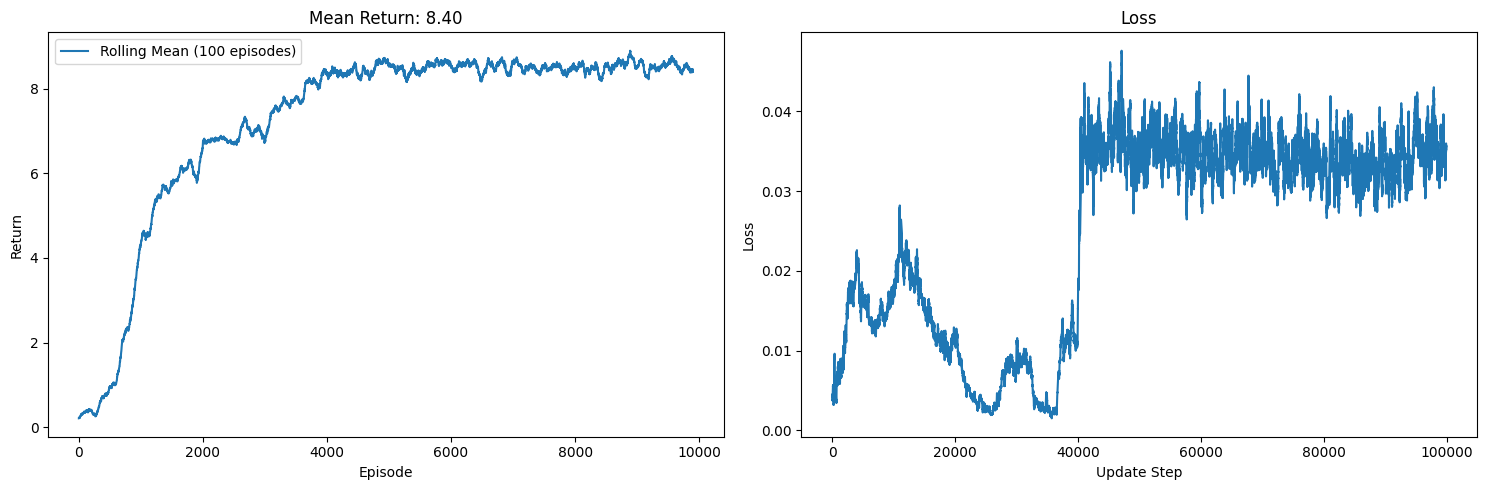

In [ ]:
from Env import VoltageDistributionEnv

env = VoltageDistributionEnv()
agent = DQNAgent(
    env= env, 
    memory_size= 10_000,
    batch_size= 64,
    target_update= 200,
    seed= 42,
    gamma= 0.995,

    # standard DQN epsilon greedy parameters
    epsilon_decay= 0.0001,
    max_epsilon= 1.0,
    min_epsilon= 0.05,

    # PER parameters
    alpha= 0.0,
    beta= 0.0,
    prior_eps= 1e-6,

    # N-step Learning
    n_step= 1,
    lr= 2.5e-4,
)

agent.train(timesteps=100_000, plotting_interval=100)